# Step 1: Minimal CrossFormer Inference Example

This Colab demonstrates how to load a pre-trained / finetuned CrossFormer checkpoint, run inference for a single-arm and bimanual manipulation system, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy

/home/x_jenlu/.conda/envs/crossformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

2024-11-21 14:46:38.370293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 14:46:38.370363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 14:46:38.371959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 14:46:39.552496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Fetching 6 files: 100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77195.78it/s]
2024-11-21 14:48:12.338993: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen 

In [3]:
import jax.numpy as jnp

def analyze_attention(model, observation, task):
    """
    Computes attention rollout from readout tokens to input tokens.
    Returns the attention rollout weights and a mapping from token indices to token names.
    
    Args:
        observations: Dictionary of observations 
        tasks: Dictionary of task specifications
        head_name: Name of the readout head to analyze
    Returns:
        rollout: Attention rollout weights from readout to input tokens
        token_map: Mapping from token indices to token types
    """
    # Run transformer with attention weights stored
    transformer_outputs = model.module.apply(
        {"params": model.params},
        observation,
        task,
        observation["timestep_pad_mask"],
        train=False,
        method="crossformer_transformer",
        mutable=["intermediates"],
    )

    outputs, variables = transformer_outputs

        # Count and print token breakdown
    token_counts = {}

    print(outputs.keys())
    # Count prefix tokens
    for prefix_group in outputs.keys():
        if prefix_group.startswith("task_"):
            n_tokens = outputs[prefix_group].tokens.shape[-2]
            token_counts[prefix_group] = n_tokens
            
    # Count observation tokens
    for obs_group in outputs.keys():
        if obs_group.startswith("obs_"):
            n_tokens = outputs[obs_group].tokens.shape[-2]
            token_counts[obs_group] = n_tokens
            
    # Count readout tokens
    head_names = ['readout_bimanual', 'readout_nav', 'readout_quadruped', 'readout_single_arm']
    for readout_key in head_names:
        if readout_key in outputs:
            n_tokens = outputs[readout_key].tokens.shape[-2]
            token_counts[readout_key] = n_tokens

    
    attention_weights = []


    
    # Extract attention weights from each transformer block
    for i in range(model.config["model"]["transformer_kwargs"]["num_layers"]):
        block_name = f'encoderblock_{i}'
        if block_name in variables['intermediates']['crossformer_transformer']['BlockTransformer_0']['Transformer_0']:
            layer_attention = variables['intermediates']['crossformer_transformer']['BlockTransformer_0']['Transformer_0'][block_name]['MultiHeadDotProductAttention_0']['attention_weights'][0]
            attention_weights.append(layer_attention)

    print("Token count breakdown:")
    total = 0
    for k, v in token_counts.items():
        print(f"{k}: {v} tokens")
        total += v
    print(f"Total tokens: {total}")

    
    # Average attention weights across heads
    attention_weights = [jnp.mean(weights, axis=1) for weights in attention_weights]
    
    # Build token type list
    token_types = []
    
    # Map prefix tokens
    for prefix_group in outputs.keys():
        print(prefix_group)
        if "_" in prefix_group:
            n_tokens = outputs[prefix_group].tokens.shape[-2]
            token_types.extend([prefix_group] * n_tokens)
            
    # # Map observation tokens
    # for obs_group in outputs.keys():
    #     if obs_group.startswith("obs_"):
    #         n_tokens = outputs[obs_group].tokens.shape[-2]
    #         token_types.extend([obs_group] * n_tokens)

    # # Map readout tokens
    # readout_key = f"readout_{head_name}"
    # if readout_key in outputs:
    #     n_tokens = outputs[readout_key].tokens.shape[-2]
    #     token_types.extend([readout_key] * n_tokens)

    # Compute attention rollout
    rollout = attention_weights[0]
    for attention in attention_weights[1:]:
        rollout = jnp.matmul(attention, rollout)
    
    # Normalize rollout
    rollout = rollout / rollout.sum(axis=-1, keepdims=True)
    
    return rollout, token_types


In [4]:
import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['CURL_CA_BUNDLE'] = certifi.where()


# create RLDS dataset builder
builder = tfds.builder_from_directory(
    builder_dir="gs://gresearch/robotics/bridge/0.1.0/"
)
ds = builder.as_dataset(split="train[:1]")

# sample episode and resize to 224x224 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode["steps"])
images = [
    cv2.resize(np.array(step["observation"]["image"]), (224, 224)) for step in steps
]

# extract goal image and language instruction
goal_image = images[-1]
language_instruction = (
    steps[0]["observation"]["natural_language_instruction"].numpy().decode()
)

# visualize episode
print(f"Instruction: {language_instruction}")
#mediapy.show_video(images, fps=10)


2024-11-21 14:48:21.854191: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Instruction: Place the can to the left of the pot.


In [5]:
WINDOW_SIZE = 1

# create task dictionary
task = model.create_tasks(
    goals={"image_primary": goal_image[None]}
)  # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])  # for language conditioned

In [6]:
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step : step + WINDOW_SIZE])[None]
    observation = {
        "image_primary": input_images,
        "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
    }

    # we need to pass in the dataset statistics to unnormalize the actions
    rollout, token_types = model.analyze_attention(observation, task)
    break


  0%|                                                                                                                 | 0/38 [00:07<?, ?it/s]

dict_keys(['obs_primary', 'readout_bimanual', 'readout_nav', 'readout_quadruped', 'readout_single_arm', 'obs'])
Token count breakdown:
obs_primary: 49 tokens
readout_bimanual: 100 tokens
readout_nav: 4 tokens
readout_quadruped: 1 tokens
readout_single_arm: 4 tokens
Total tokens: 158
obs_primary
readout_bimanual
readout_nav
readout_quadruped
readout_single_arm
obs


In [12]:
print(rollout.shape)

(1, 158, 158)


[149, 150, 151, 152]


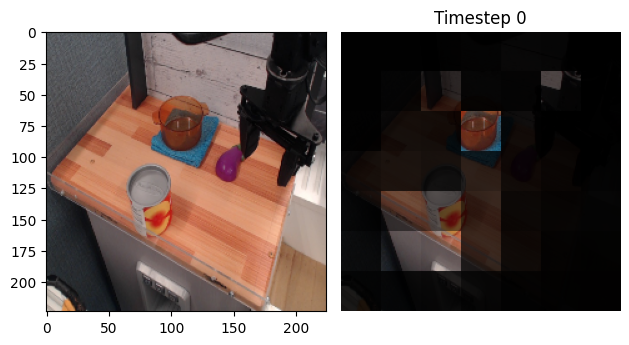

In [13]:
from crossformer.utils import visualization_utils
import importlib
importlib.reload(visualization_utils)
fig = visualization_utils.plot_readout_attention(rollout, token_types, "readout_nav", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0])

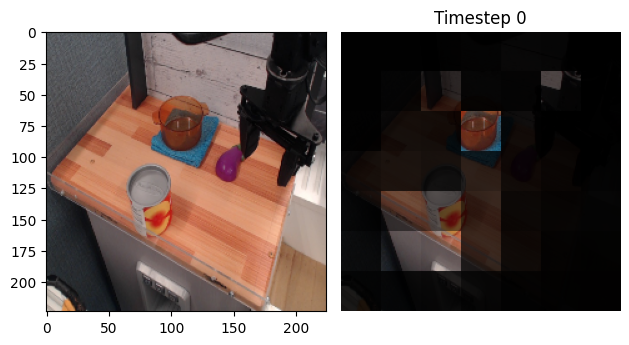

In [11]:
fig = visualization_utils.plot_readout_attention(rollout, token_types, "readout_single_arm", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0])